In [157]:
%reload_ext lab_black

%matplotlib inline
from matplotlib import style

style.use("fivethirtyeight")
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import datetime as dt
import timestring

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

* Design a query to retrieve the last 12 months of precipitation data

In [160]:
twelve_mos_prcp = (
    session.query(Measurement.date).order_by(Measurement.date.desc()).first()
)
print(twelve_mos_prcp)

('2017-08-23',)


* Calculate the date 1 year ago from the last data point in the database

In [178]:
one_year_ago = dt.datetime.strptime(twelve_mos_prcp[0], "%Y-%m-%d") - dt.timedelta(
    days=366
)
print(one_year_ago)

2016-08-22 00:00:00


* Perform a query to retrieve the data and precipitation scores

In [179]:
data_prcp_qry = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= one_year_ago)
    .all()
)
# print(dt_prcp_qry)

* Save the query results as a Pandas DataFrame and set the index to the date column

In [180]:
prcp_df = pd.DataFrame(data_prcp_qry, columns=["date", "precipitation"])
prcp_df.set_index("date", inplace=True)
prcp_df

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


* Sort the dataframe by date

In [102]:
prcp_df_sorted = prcp_df.sort_values(by="date", ascending=True)
prcp_df_sorted

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


* Use Pandas Plotting with Matplotlib to plot the data

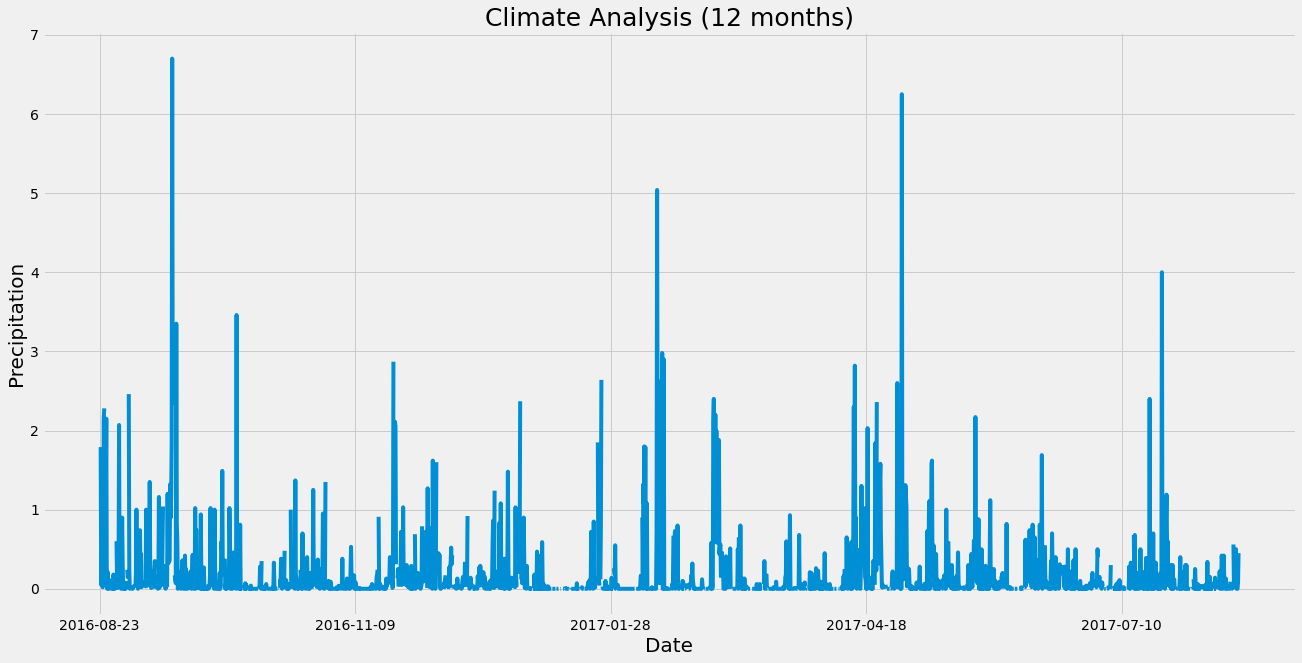

In [174]:
prcp_df_sorted.plot(use_index=True, legend=False)
plt.gcf().set_size_inches((20, 10))
plt.title("Climate Analysis (12 months)", fontsize=25)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Precipitation", fontsize=20)
plt.savefig("Images/Precipitation.png")
plt.show()

* Use Pandas to calcualte the summary statistics for the precipitation data

In [45]:
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [187]:
# Design a query to show how many stations are available in this dataset?
stations_available = session.query(Measurement.station).distinct().count()
#stations_available = session.query(Measurement.station).distinct().all()
stations_available

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [95]:
stations_active = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)
stations_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


[(54.0, 85.0, 71.66378066378067)]

In [94]:
temps = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs),
    )
    .filter(Measurement.station == stations_active[0][0])
    .all()
)
temps

[(54.0, 85.0, 71.66378066378067)]

In [85]:
# Choose the station with the highest number of temperature observations.
highest_tempobs_station = stations_active[0][0]

# Query the last 12 months of temperature observation data for this station
temp_obs = (
    session.query(Measurement.tobs)
    .filter(Measurement.date >= one_year_ago)
    .filter(Measurement.station == highest_tempobs_station)
    .all()
)
temp_obs = pd.DataFrame(temp_obs, columns=["temperature"])
temp_obs

,temperature
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


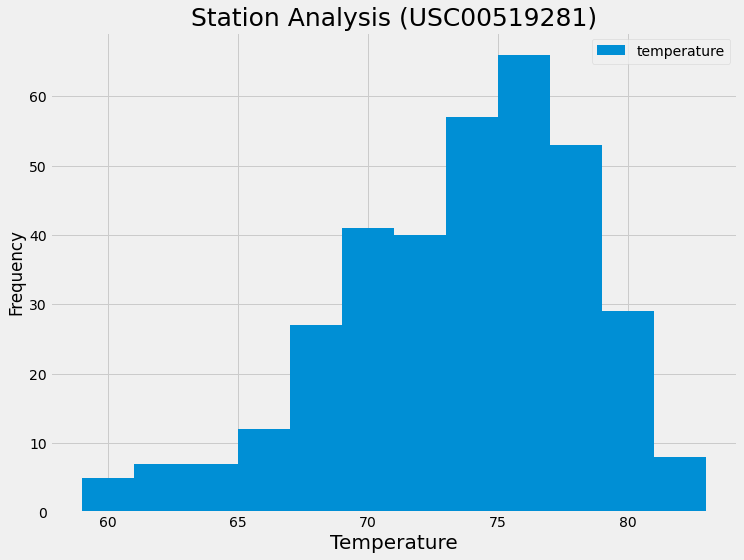

In [164]:
# plot the results as a histogram
temp_obs.plot.hist(bins=12)
plt.title("Station Analysis (USC00519281)", fontsize=25)
plt.xlabel("Temperature", fontsize=20)
plt.tight_layout()
plt.gcf().set_size_inches((12, 10))
plt.savefig("Images/Temperature_Observation.png")
plt.show()

In [165]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d'
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """

    return (
        session.query(
            func.min(Measurement.tobs),
            func.avg(Measurement.tobs),
            func.max(Measurement.tobs),
        )
        .filter(Measurement.date >= start_date)
        .filter(Measurement.date <= end_date)
        .all()
    )


# function usage example
print(calc_temps("2012-02-28", "2012-03-05"))

[(62.0, 69.57142857142857, 74.0)]


In [188]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax
# for your trip using the previous year's data for those same dates.
trip_dates = calc_temps("2016-03-05", "2016-03-15")
trip_dates

[(63.0, 70.66666666666667, 78.0)]

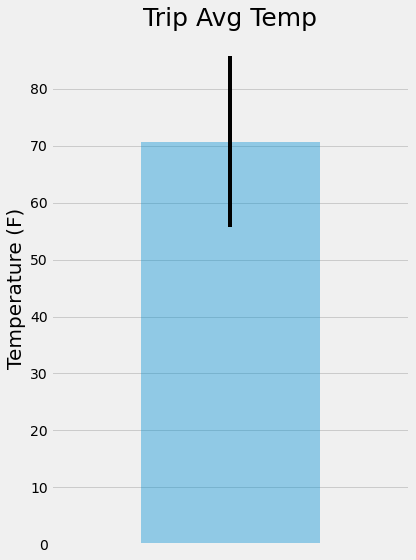

In [203]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_avg_temp_df = pd.DataFrame(trip_dates, columns=["tmin", "tavg", "tmax"])

trip_avg_temp_df.plot.bar(
    y="tavg",
    yerr=(trip_avg_temp_df["tmax"] - trip_avg_temp_df["tmin"]),
    alpha=0.4,
    legend=False,
)
plt.gcf().set_size_inches((6, 8))
plt.title("Trip Avg Temp", fontsize=25)
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temperature (F)", fontsize=20)
plt.tight_layout()
plt.savefig("Images/TripAvgTemp.png")
plt.show()

In [173]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def rainfall(start_date, end_date):

    info = [
        Measurement.station,
        Station.name,
        Station.latitude,
        Station.longitude,
        Station.elevation,
        Measurement.prcp,
    ]

    return (
        session.query(*info)
        .filter(Measurement.station == Station.station)
        .filter(Measurement.date >= start_date)
        .filter(Measurement.date <= end_date)
        .group_by(Measurement.station)
        .order_by(Measurement.prcp.desc())
        .all()
    )

print(rainfall("2017-03-05", "2017-03-15"))

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.41), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.35), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.35), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.1), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, None), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, None)]


## Optional Challenge Assignment

In [181]:
# Create a query that will calculate the daily normals
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)


def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """

    sel = [
        func.min(Measurement.tobs),
        func.avg(Measurement.tobs),
        func.max(Measurement.tobs),
    ]
    return (
        session.query(*sel)
        .filter(func.strftime("%m-%d", Measurement.date) == date)
        .all()
    )


daily_normals("03-05")

[(60.0, 67.89090909090909, 76.0)]

In [190]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = "2016-03-05"
end_date = "2016-03-15"

# Use the start and end date to create a range of dates

date_range = (
    session.query(Measurement.date)
    .filter(Measurement.date >= start_date)
    .filter(Measurement.date <= end_date)
    .group_by(Measurement.date)
    .all()
)

# Stip off the year and save a list of %m-%d strings

trip_date_range = [x[0] for x in date_range]
trip_date_range_no_year = [x[5:] for x in trip_date_range]


# Loop through the list of %m-%d strings and calculate the normals for each date

daily_normals = [
    session.query(
        func.min(Measurement.tobs),
        func.avg(Measurement.tobs),
        func.max(Measurement.tobs),
    )
    .filter(func.strftime("%m-%d", Measurement.date) >= trip_date_range_no_year[0])
    .filter(func.strftime("%m-%d", Measurement.date) <= trip_date_range_no_year[-1])
    .group_by(func.strftime("%m-%d", Measurement.date))
    .all()
]

daily_normals = daily_normals[0]
daily_normals

[(60.0, 67.89090909090909, 76.0),
 (60.0, 69.20338983050847, 76.0),
 (60.0, 69.17241379310344, 78.0),
 (59.0, 68.72413793103448, 78.0),
 (57.0, 68.56140350877193, 75.0),
 (57.0, 69.12280701754386, 75.0),
 (60.0, 69.89285714285714, 82.0),
 (62.0, 69.88888888888889, 80.0),
 (56.0, 69.29629629629629, 77.0),
 (62.0, 70.32758620689656, 77.0),
 (58.0, 68.54716981132076, 76.0)]

In [191]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

daily_normals_df = pd.DataFrame(daily_normals, columns=["tmin", "tavg", "tmax"])
daily_normals_df["date"] = trip_date_range
daily_normals_df["date"] = pd.to_datetime(daily_normals_df["date"], format="%Y-%m-%d")
daily_normals_df.set_index("date", inplace=True)

daily_normals_df

,tmin,tavg,tmax
date,,,
2016-03-05,60.0,67.890909,76.0
2016-03-06,60.0,69.203390,76.0
2016-03-07,60.0,69.172414,78.0
2016-03-08,59.0,68.724138,78.0
2016-03-09,57.0,68.561404,75.0
2016-03-10,57.0,69.122807,75.0
2016-03-11,60.0,69.892857,82.0
2016-03-12,62.0,69.888889,80.0
2016-03-13,56.0,69.296296,77.0


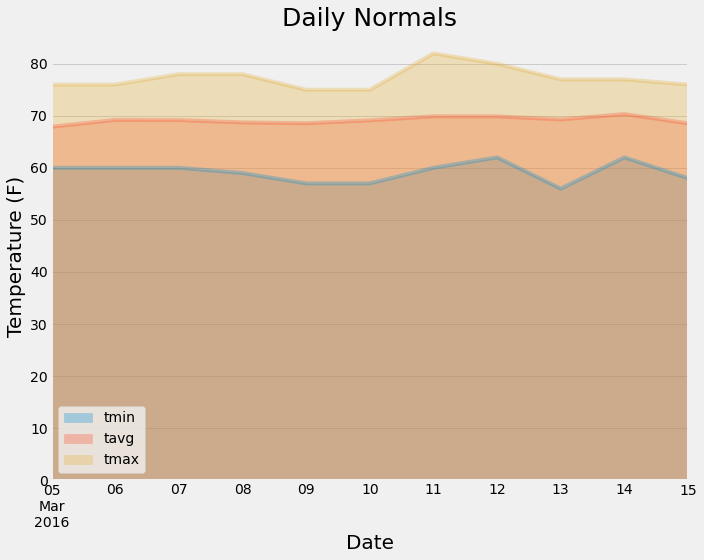

In [192]:
# Plot the daily normals as an area plot with `stacked=False`

daily_normals_df.plot(kind="area", alpha=0.3, stacked=False)
plt.gcf().set_size_inches((10, 8))
plt.title("Daily Normals", fontsize=25)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Temperature (F)", fontsize=20)
plt.tight_layout()
plt.savefig("Images/DailyNormals.png")
plt.show()